# Capstone Project 2

Reuben Hough

In [1]:
# Importing Libraries      
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import os
%matplotlib inline
import sys
import pandas as pd
import pandas.util.testing as tm
from pandas import DataFrame
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from numpy import random
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX as SX
from statsmodels.tsa.seasonal import seasonal_decompose as decomp
from statsmodels.tsa.stattools import adfuller
import itertools
register_matplotlib_converters()
from time import time
import math
from fbprophet import Prophet
from collections import OrderedDict
import cProfile

## Reading Data

In [2]:
Fielder = pd.read_csv('FielderStats.csv')
Pitcher = pd.read_csv('PitcherStats.csv')

In [3]:
FC = Fielder.columns.tolist()[1:]
PC = Pitcher.columns.tolist()[1:]

## Checking for multicollinearity

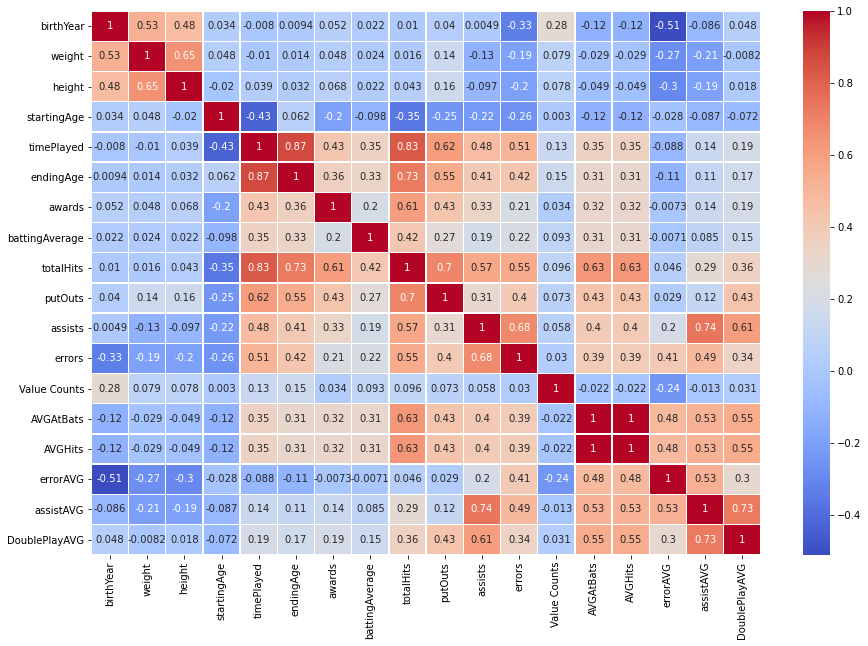

In [4]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(Fielder[FC].corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

In [5]:
# Getting rid of the most heavily correlated columns
Fielder.drop(['timePlayed', 'totalHits', 'AVGAtBats'], axis=1, inplace=True)

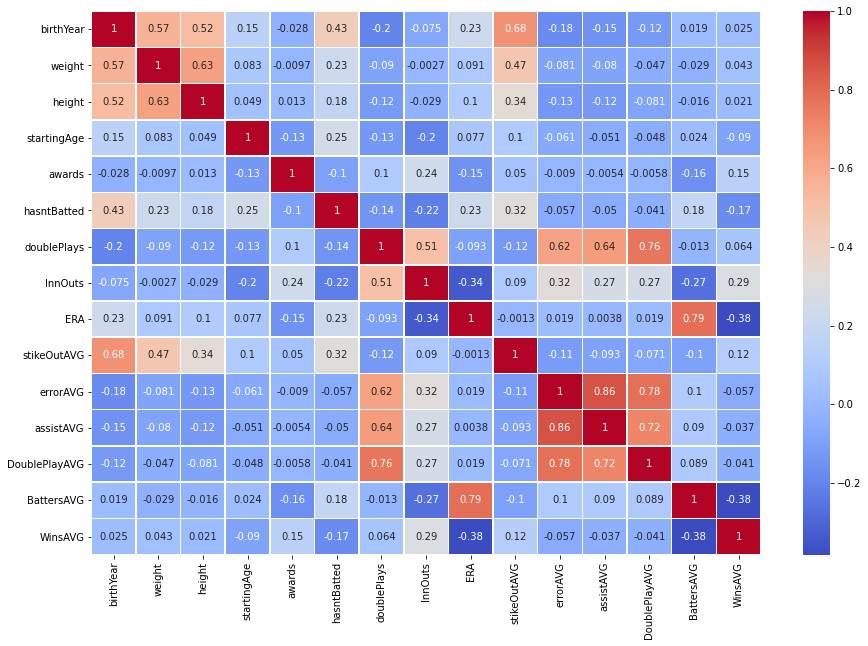

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(Pitcher[PC].corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

In [7]:
Pitcher.drop(['assistAVG'], axis=1, inplace=True)

I'm going to attempt to cut down the training data and see what kind of difference it makes.

In [8]:
# This will let me change text colors easily
class bcolors:
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    END = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [9]:
# This function will let me easily compare the ratios of awarded to non-awarded players
def FindRatios(DF1,DF2):
    DF3 = DF1.copy()
    DF4 = DF2.copy()
    DF3['awards'] = DF3['awards'].where(DF3['awards'] < 0.2, 1)
    DF4['awards'] = DF4['awards'].where(DF4['awards'] < 0.2, 1)
    F3 = DF3['awards'].value_counts()
    F4 = DF4['awards'].value_counts()
    FF = ["The ratio of non-awarded to awarded players",
          f"started at {bcolors.GREEN}{bcolors.BOLD}{round((F3[0])/(F3[1]), 2)}{bcolors.END}",
          f"and ended at {bcolors.BLUE}{bcolors.BOLD}{round((F4[0])/(F4[1]), 2)}{bcolors.END},",
          f"while retaining {bcolors.GREEN}{bcolors.BOLD}{F4[1]}{bcolors.END} awards",
          f"out of {bcolors.GREEN}{bcolors.BOLD}{F3[1]}{bcolors.END}"]
    print(' '.join(FF))

In [10]:
Pitcher.head(10)

,playerID,birthYear,weight,height,startingAge,awards,hasntBatted,doublePlays,InnOuts,ERA,stikeOutAVG,errorAVG,DoublePlayAVG,BattersAVG,WinsAVG
0,aardsda01,1981.0,215.0,75.0,22.33,0,1.0,2.0,331.0,4.273,9.080,0.080,0.053,39.392,0.427
1,aasedo01,1954.0,190.0,75.0,22.83,0,1.0,10.0,448.0,3.797,5.200,0.105,0.081,38.374,0.535
2,abadfe01,1985.0,235.0,74.0,24.58,0,0.0,2.0,384.0,3.674,7.621,0.054,0.054,38.078,0.218
3,abbeybe01,1869.0,175.0,71.0,22.58,0,0.0,4.0,79.0,4.516,2.551,0.349,0.063,40.690,0.349
4,abbotgl01,1951.0,200.0,78.0,22.42,0,1.0,12.0,248.0,4.388,3.387,0.119,0.084,38.547,0.434
5,abbotji01,1967.0,200.0,75.0,21.58,2,0.0,16.0,263.0,4.253,4.774,0.048,0.086,38.769,0.468
6,abbotky01,1968.0,200.0,76.0,23.58,0,0.0,0.0,57.0,5.196,6.022,0.049,0.000,39.577,0.194
7,abbotpa01,1967.0,185.0,75.0,22.92,0,0.0,8.0,162.0,4.920,6.194,0.075,0.100,39.801,0.537
8,aberal01,1927.0,195.0,74.0,23.17,0,0.0,5.0,144.0,4.184,3.907,0.139,0.116,39.252,0.555
9,abernte02,1933.0,215.0,76.0,22.08,2,0.0,16.0,681.0,3.458,5.999,0.165,0.125,38.920,0.494


In [11]:
Pitcher2 = Pitcher.copy()
Pitcher2['InnOuts'] = Pitcher2['InnOuts'].where(Pitcher2['InnOuts'] > 34, np.NaN)
Pitcher2['height'] = Pitcher2['height'].where(Pitcher2['height'] > 65, np.NaN)
Pitcher2['DoublePlayAVG'] = Pitcher2['DoublePlayAVG'].where(Pitcher2['DoublePlayAVG'] > 0, np.NaN)
Pitcher2['WinsAVG'] = Pitcher2['WinsAVG'].where(Pitcher2['WinsAVG'] > 0.2, np.NaN)
Pitcher2['BattersAVG'] = Pitcher2['BattersAVG'].where(Pitcher2['BattersAVG'] < 42, np.NaN)
Pitcher2['hasntBatted'] = Pitcher2['hasntBatted'].where(Pitcher2['hasntBatted'] == 0, np.NaN)
Pitcher2['ERA'] = Pitcher2['ERA'].where(Pitcher2['ERA'] <=5, np.NaN)
Pitcher2 = Pitcher2.dropna()
FindRatios(Pitcher,Pitcher2)

The ratio of non-awarded to awarded players started at 14.64 and ended at 6.36, while retaining 300 awards out of 361


In [12]:
Fielder2 = Fielder.copy()
Fielder2['assistAVG'] = Fielder2['assistAVG'].where(Fielder2['assistAVG'] > 0, np.NaN)
Fielder2['battingAverage'] = Fielder2['battingAverage'].where(Fielder2['battingAverage'] >=0.22, np.NaN)
Fielder2 = Fielder2.dropna()
FindRatios(Fielder,Fielder2)

The ratio of non-awarded to awarded players started at 7.69 and ended at 5.42, while retaining 676 awards out of 682


In [13]:
Fielder2['awards'] = Fielder2['awards'].where(Fielder2['awards'] < 1.2, 2)
Fielder2['awards'].value_counts()

0    3667
2     477
1     199
Name: awards, dtype: int64

In [14]:
Pitcher2['awards'] = Pitcher2['awards'].where(Pitcher2['awards'] < 1.2, 2)
Pitcher2['awards'].value_counts()

0    1908
2     192
1     108
Name: awards, dtype: int64

Here I made any more than one award equal to two, to simplify categories, and to try and prevent the classifiers from putting all into the no award category.

## Testing Pitchers

In [15]:
def TestTrain(df):
    y = df['awards']
    x = df.drop(['awards', 'playerID'], axis=1)
    x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=1)
    w = x_train,x_test,y_train,y_test
    return w

In [16]:
# Using several classifiers to test the data
classifiers = [RidgeClassifier(random_state=1),KNeighborsClassifier(),
               RandomForestClassifier(random_state=1),AdaBoostClassifier(random_state=1),
               DecisionTreeClassifier(random_state=1)]
classifiernames = ['Ridge','KNN',"Random Forest","Adaboost","Decision Tree"]

In [17]:
# Prints accuracy of classification method,
# and provides a visual confusion matrix
def statistics(clf, w):
    print(clf)
    clf.fit(w[0], w[2])
    pred = clf.predict(w[1])
    score = metrics.accuracy_score(w[3], pred)
    print("accuracy:   %0.3f" % score)
    matrix = metrics.confusion_matrix(w[3], pred)
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, matrix

In [18]:
Pitchresults = []
for clf in classifiers:
    Pitchresults.append(statistics(clf, TestTrain(Pitcher2)))

RidgeClassifier(random_state=1)
accuracy:   0.880

KNeighborsClassifier()
accuracy:   0.875

RandomForestClassifier(random_state=1)
accuracy:   0.899

AdaBoostClassifier(random_state=1)
accuracy:   0.879

DecisionTreeClassifier(random_state=1)
accuracy:   0.844



In [19]:
def Matrix(results, x, name):
    LW = list(range(len(results[x][2])))
    cm = pd.DataFrame(results[x][2], index = [i for i in LW],
                  columns = [i for i in LW])
    plt.figure(figsize = (10,7))
    plt.title(name[x])
    sns.heatmap(cm, annot=True)

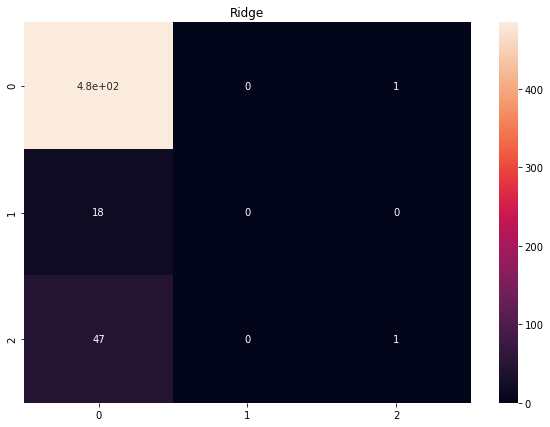

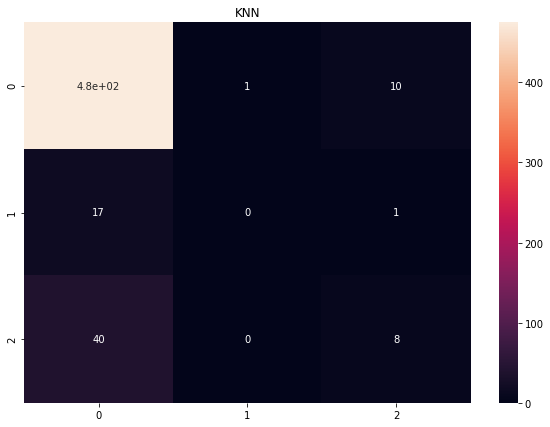

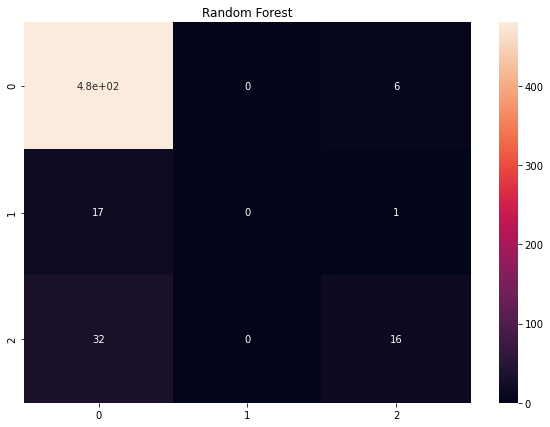

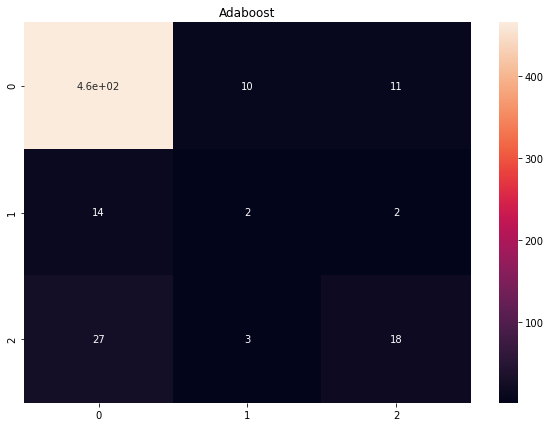

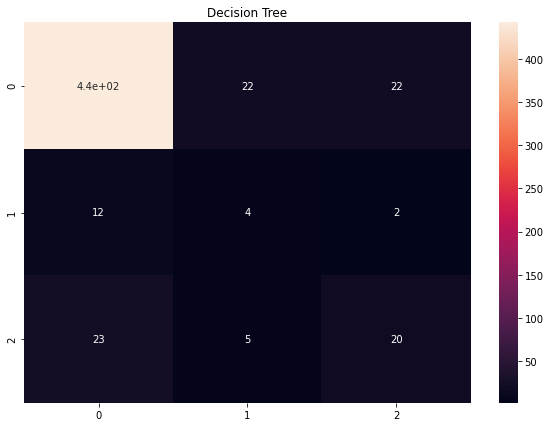

In [21]:
indices = np.arange(len(Pitchresults))
for x in indices:
    Matrix(Pitchresults, x, classifiernames)

## Testing Fielders

In [22]:
Fieldresults = []
for clf in classifiers:
    Fieldresults.append(statistics(clf, TestTrain(Fielder2)))

RidgeClassifier(random_state=1)
accuracy:   0.874

KNeighborsClassifier()
accuracy:   0.862

RandomForestClassifier(random_state=1)
accuracy:   0.897

AdaBoostClassifier(random_state=1)
accuracy:   0.886

DecisionTreeClassifier(random_state=1)
accuracy:   0.847



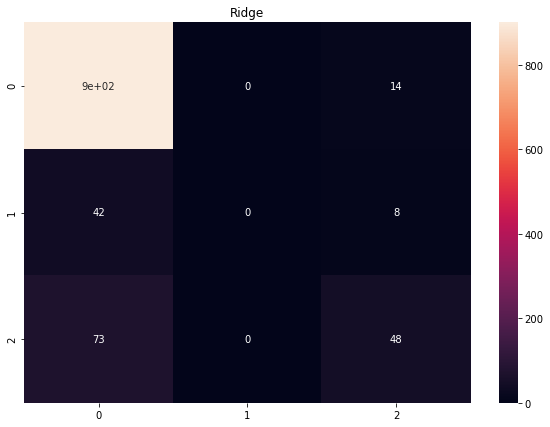

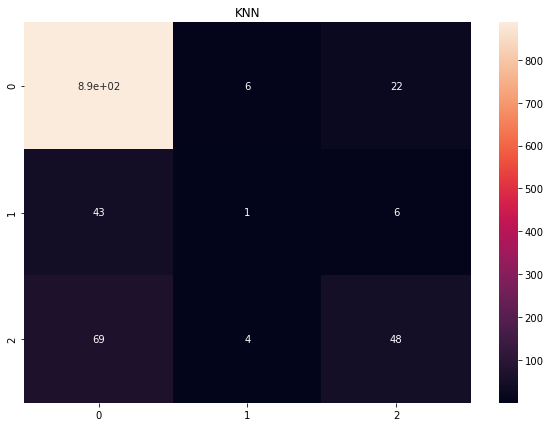

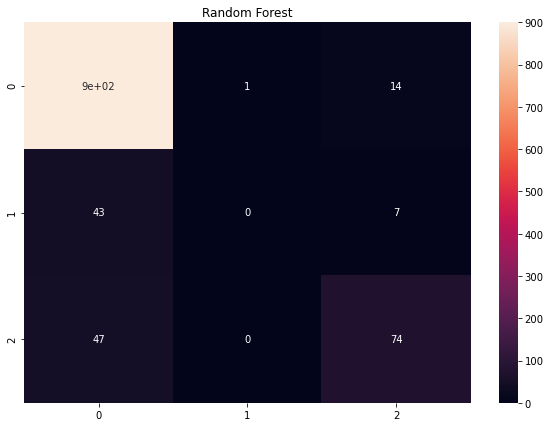

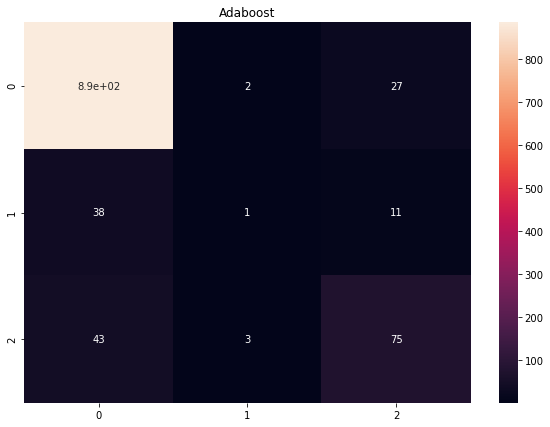

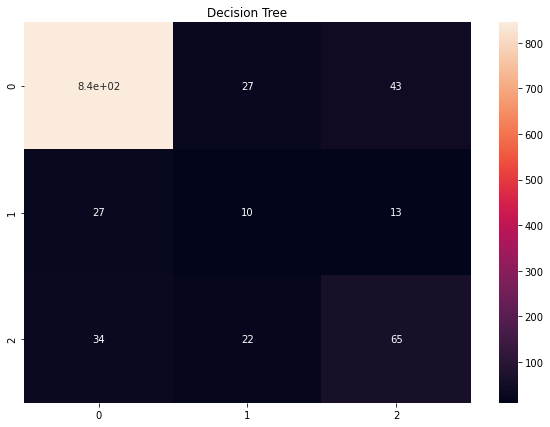

In [23]:
indices = np.arange(len(Fieldresults))
for x in indices:
    Matrix(Fieldresults, x, classifiernames)

These are not great results as far as correctly classifying awards, especially for pitchers. It's possible that awards are somewhat arbitrarily handed out.

In [24]:
# Here I'm going to try to improve the classification by changing the parameters
def SepAward(df):
    data = pd.get_dummies(df,prefix=['awards'], columns = ['awards'], drop_first=False)
    # It may be useful to see each category independently
    NoAward = data.copy()
    OneAward = data.copy()
    TwoAward = data.copy()
    # Making dataframes with only one status accounted for
    NoAward.drop(['awards_1', 'awards_2'], axis=1, inplace=True)
    OneAward.drop(['awards_0', 'awards_2'], axis=1, inplace=True)
    TwoAward.drop(['awards_0', 'awards_1'], axis=1, inplace=True)
    y0 = NoAward['awards_0']
    x0 = NoAward.drop(['awards_0', 'playerID'], axis=1)
    y1 = OneAward['awards_1']
    x1 = OneAward.drop(['awards_1', 'playerID'], axis=1)
    y2 = TwoAward['awards_2']
    x2 = TwoAward.drop(['awards_2', 'playerID'], axis=1)
    # Test/train splitting all of them
    x0train, x0test, y0train, y0test = train_test_split(x0, y0, random_state=1)
    x1train, x1test, y1train, y1test = train_test_split(x1, y1, random_state=1)
    x2train, x2test, y2train, y2test = train_test_split(x2, y2, random_state=1)
    w0 = x0train, x0test, y0train, y0test
    w1 = x1train, x1test, y1train, y1test
    w2 = x2train, x2test, y2train, y2test
    w3 = w0, w1, w2
    return w3

In [25]:
Pits = SepAward(Pitcher2)
Fiels = SepAward(Fielder2)

## Random Forest Classifier Optimization

Here I'm going to change a few parameters of the classifiers to see if they can work better

In [26]:
# These are several functions that iterate through parameters to find what works best
def RFEst(w):
    n_estimators = np.linspace(10, 100, 4, endpoint=True, dtype='int')
    train_results0 = []
    train_results1 = []
    train_results2 = []
    train_results3 = []
    test_results0 = []
    test_results1 = []
    test_results2 = []
    test_results3 = []
    for n_estimator in n_estimators:
        dt = RandomForestClassifier(n_estimators=n_estimator, random_state=1)
        dt.fit(w[0][0], w[0][2])
        dt.fit(w[1][0], w[1][2])
        dt.fit(w[2][0], w[2][2])
        train_pred0 = dt.predict(w[0][0])
        train_pred1 = dt.predict(w[1][0])
        train_pred2 = dt.predict(w[2][0])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][2], train_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][2], train_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][2], train_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        # Add auc score to previous train results
        train_results0.append(roc_auc0)
        train_results1.append(roc_auc1)
        train_results2.append(roc_auc2)
        train_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
        y_pred0 = dt.predict(w[0][1])
        y_pred1 = dt.predict(w[1][1])
        y_pred2 = dt.predict(w[2][1])
        false_positive_rate0, true_positive_rate0, thresholds0 = roc_curve(w[0][3], y_pred0)
        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(w[1][3], y_pred1)
        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(w[2][3], y_pred2)
        roc_auc0 = auc(false_positive_rate0, true_positive_rate0)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        # Add auc score to previous test results
        test_results0.append(roc_auc0)
        test_results1.append(roc_auc1)
        test_results2.append(roc_auc2)
        test_results3.append(roc_auc0 + roc_auc1 + roc_auc2)
    plt.figure(figsize=(12,6))
    plt.plot(n_estimators, train_results0, 'b', label='No Award Train AUC')
    plt.plot(n_estimators, test_results0, 'cornflowerblue', label='No Award Test AUC')
    plt.plot(n_estimators, train_results1, 'r', label='One Award Train AUC')
    plt.plot(n_estimators, test_results1, 'firebrick', label='One Award Test AUC')
    plt.plot(n_estimators, train_results2, 'g', label='Two Awards Train AUC')
    plt.plot(n_estimators, test_results2, 'lime', label='Two Awards Test AUC')
    plt.plot(n_estimators, train_results3, 'black', label='Total Train AUC')
    plt.plot(n_estimators, test_results3, 'dimgray', label='Total Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel('Number of Estimators')
    plt.legend()
    plt.show()

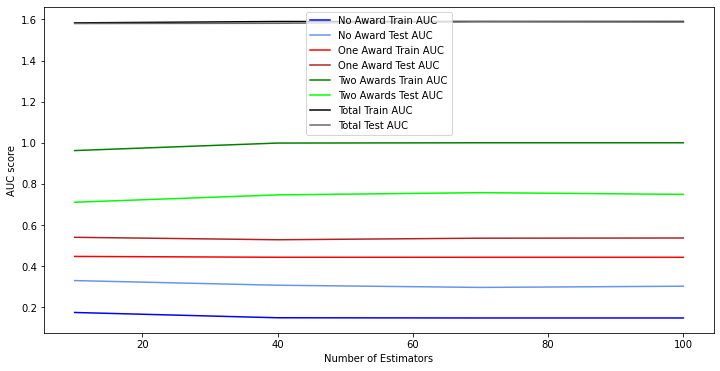

In [27]:
RFEst(Fiels)

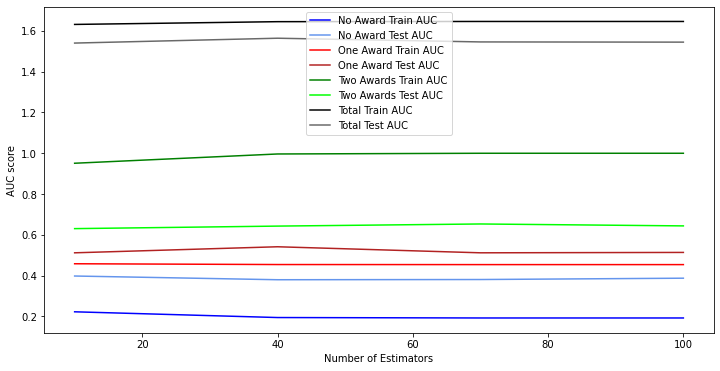

In [28]:
RFEst(Pits)

The number of estimators seems to even out around 40, but these graphs are rather difficult to look at.

## Pipeline

Rather than looking at graphs for the rest of them, I'll just use a pipeline to find the best hyperparameter tuning for each classifier.

In [29]:
# Here I'm setting up a pipline and grid search for each set of parameters
# I feed into a classifier
def PIPE(w, name, classifier, grid):
    X_train, X_test, y_train, y_test = w
    # The data is also scaled first
    Pipe = Pipeline([('ss', StandardScaler()), (name, classifier)])
    gridsearch = GridSearchCV(estimator=Pipe,param_grid=grid, 
                          scoring='accuracy', cv=5)
    gridsearch.fit(X_train, y_train)
    score = gridsearch.score(X_test, y_test)
    return score

# This gives me the keys I need to put into the grid because they have strange names
def GetKeys(classifier, name):
    Pipe = Pipeline([('ss', StandardScaler()), (name, classifier)])
    return Pipe.get_params().keys()

In [30]:
Pits = TestTrain(Pitcher2)
Fiels = TestTrain(Fielder2)

## Ridge Classifier

In [31]:
RCparametergrid = {'RC__class_weight': ['balanced_subsample', 'balanced'],
                   'RC__max_iter': list(range(1, Pits[0].shape[1])),'RC__solver':['auto', 'svd', 'saga', 'lsqr']}

In [32]:
RCPitcher = PIPE(Pits, "RC", RidgeClassifier(random_state=1), RCparametergrid)
RCPitcher

0.769927536231884

In [33]:
RCFielder = PIPE(Fiels, "RC", RidgeClassifier(random_state=1), RCparametergrid)
RCFielder

0.8204419889502762

Unfortunately the ridge classifier had difficulty with a relatively large dataset and did not correctly converge.

## K-Nearest Neighbors

In [34]:
KNNparametergrid = {'KNN__weights': ['uniform', 'distance'],
                    'KNN__algorithm': ['auto','ball_tree','kd_tree','brute'],'KNN__p':[1,2,3]}

In [35]:
KNNPitcher = PIPE(Pits, "KNN", KNeighborsClassifier(), KNNparametergrid)
KNNPitcher

0.8840579710144928

In [36]:
KNNFielder = PIPE(Fiels, "KNN", KNeighborsClassifier(), KNNparametergrid)
KNNFielder

0.8802946593001841

## Random Forest Classifier

In [37]:
RFFparametergrid = {'RFC__max_depth': [4, 5, 6],'RFC__min_samples_split': [2, 5, 10],
                    'RFC__min_samples_leaf': [1, 3, 5], 'RFC__max_features':['auto', 'sqrt', 'log2']}

In [38]:
RFFPitcher = PIPE(Pits, "RFC", RandomForestClassifier(random_state=1), RFFparametergrid)
RFFPitcher

0.9021739130434783

In [39]:
RFFFielder = PIPE(Fiels, "RFC", RandomForestClassifier(random_state=1), RFFparametergrid)
RFFFielder

0.8913443830570903

## AdaBoost Classifier

In [40]:
AdaBoostClassifier(random_state=1)

AdaBoostClassifier(random_state=1)

In [41]:
Adaparametergrid = {'ADA__algorithm':['SAMME','SAMME.R'], 'ADA__learning_rate':[1,2,3], 'ADA__n_estimators':[5,25,50,60]}

In [42]:
AdaPitcher = PIPE(Pits, "ADA", AdaBoostClassifier(random_state=1), Adaparametergrid)
AdaPitcher

0.8894927536231884

In [43]:
AdaFielder = PIPE(Fiels, "ADA", AdaBoostClassifier(random_state=1), Adaparametergrid)
AdaFielder

0.8950276243093923

## Decision Tree Classifier

In [44]:
DTCparametergrid = {'DTC__criterion':['gini','entropy'],'DTC__min_samples_split':[2,3,4],
                   'DTC__splitter':['best','random'], 'DTC__max_depth':[5,15,None]}

In [45]:
GetKeys(DecisionTreeClassifier(random_state=1), "DTC")

dict_keys(['memory', 'steps', 'verbose', 'ss', 'DTC', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'DTC__ccp_alpha', 'DTC__class_weight', 'DTC__criterion', 'DTC__max_depth', 'DTC__max_features', 'DTC__max_leaf_nodes', 'DTC__min_impurity_decrease', 'DTC__min_impurity_split', 'DTC__min_samples_leaf', 'DTC__min_samples_split', 'DTC__min_weight_fraction_leaf', 'DTC__presort', 'DTC__random_state', 'DTC__splitter'])

In [46]:
DTCPitcher = PIPE(Pits, "DTC", DecisionTreeClassifier(random_state=1), DTCparametergrid)
DTCPitcher

0.8695652173913043

In [47]:
DTCFielder = PIPE(Fiels, "DTC", DecisionTreeClassifier(random_state=1), DTCparametergrid)
DTCFielder

0.8858195211786372

## Comparing Results

In [48]:
Pitching = [RCPitcher,KNNPitcher,RFFPitcher,AdaPitcher,DTCPitcher]
Fielding = [RCFielder,KNNFielder,RFFFielder,AdaFielder,DTCFielder]

In [49]:
for x in range(len(Pitching)):
    old = round(Pitchresults[x][1],3)
    new = round(Pitching[x],3)
    name = Pitchresults[x][0]
    div = 100*(round(new/old, 3))
    print(f"{name} was {old}, now it's {div}% of that, at {new}")

RidgeClassifier was 0.88, now it's 87.5% of that, at 0.77
KNeighborsClassifier was 0.875, now it's 101.0% of that, at 0.884
RandomForestClassifier was 0.899, now it's 100.29999999999998% of that, at 0.902
AdaBoostClassifier was 0.879, now it's 101.1% of that, at 0.889
DecisionTreeClassifier was 0.844, now it's 103.1% of that, at 0.87


In [50]:
for x in range(len(Fielding)):
    old = round(Fieldresults[x][1],3)
    new = round(Fielding[x],3)
    name = Fieldresults[x][0]
    div = 100*(round(new/old, 3))
    print(f"{name} was {old}, now it's {div}% of that, at {new}")

RidgeClassifier was 0.874, now it's 93.8% of that, at 0.82
KNeighborsClassifier was 0.862, now it's 102.1% of that, at 0.88
RandomForestClassifier was 0.897, now it's 99.3% of that, at 0.891
AdaBoostClassifier was 0.886, now it's 101.0% of that, at 0.895
DecisionTreeClassifier was 0.847, now it's 104.60000000000001% of that, at 0.886


There was a small improvement in almost all classification, other than Ridge.

In [51]:
print(max(Fielding))
print(max(Pitching))

0.8950276243093923
0.9021739130434783


Both got to approximately 90 percent accuracy at best.

## Binary Classification

Here I'm looking to see how much the accuracy improves when classifying players strictly based on whether or not they received any award. There is a modest improvement, however I think it's important to be able to identify the players who may get many awards, even if it sacrifices a little accuracy.

In [52]:
Fielder3 = Fielder2.copy()
Fielder3['awards'] = Fielder3['awards'].where(Fielder3['awards'] < 0.2, 1)
Pitcher3 = Pitcher2.copy()
Pitcher3['awards'] = Pitcher3['awards'].where(Pitcher3['awards'] < 0.2, 1)

In [53]:
results = []
for clf in classifiers:
    results.append(statistics(clf, TestTrain(Pitcher3)))

RidgeClassifier(random_state=1)
accuracy:   0.884

KNeighborsClassifier()
accuracy:   0.871

RandomForestClassifier(random_state=1)
accuracy:   0.906

AdaBoostClassifier(random_state=1)
accuracy:   0.888

DecisionTreeClassifier(random_state=1)
accuracy:   0.839



In [54]:
results = []
for clf in classifiers:
    results.append(statistics(clf, TestTrain(Fielder3)))

RidgeClassifier(random_state=1)
accuracy:   0.891

KNeighborsClassifier()
accuracy:   0.886

RandomForestClassifier(random_state=1)
accuracy:   0.910

AdaBoostClassifier(random_state=1)
accuracy:   0.897

DecisionTreeClassifier(random_state=1)
accuracy:   0.878



## Conclusion

There was only very minor improvement trying to change the parameters of the classifiers. Most of the ~90 percent accuracy was in placing lots of the players into the no award category. Perhaps I need to get more information on the purpose of said awards, as they may not necessarily be for skill.

The models were not great at classifying players who only received one medal. It's possible that these players aren't significantly better than the norm, but were recognized for a particular feat.

It seems that Random Forest is able to classify highly awarded players, which means that perhaps awards aren't so arbitrary after all, but I believe this needs more investigation.